# Building a Tiny Transformer Language Model using TensorFlow

In this lab, you'll implement a simplified Transformer-based language model using TensorFlow and Keras. You'll work with a real-world text (from a PDF or a webpage) and build, train, and experiment with a tiny language model.

**Note:** This model is intentionally small and trained on limited data. The generated text might be funny or incomplete, but the goal is to understand the building blocks of Transformers.

## 1. Setup and Import Libraries

Make sure you have the required packages installed:

```bash
pip install tensorflow numpy PyPDF2 beautifulsoup4 requests
```

Now, import the libraries:

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import math

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.15.0


## 2. Define Model Components

We'll build the following components:

- **Positional Encoding**
- **Multi-Head Self-Attention**
- **Feed-Forward Network**
- **Transformer Block**
- **Tiny Transformer Language Model**

### 2.1 Positional Encoding

This layer adds positional information to token embeddings.

In [5]:
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model # int, 

        # Create a matrix of shape (max_len, d_model) with positional encodings
        pos_enc = np.zeros((max_len, d_model))
        pos = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pos_enc[:, 0::2] = np.sin(pos * div_term)
        pos_enc[:, 1::2] = np.cos(pos * div_term)
        pos_enc = pos_enc[np.newaxis, ...]  # Shape: (1, max_len, d_model)
        self.pos_enc = tf.cast(pos_enc, dtype=tf.float32)

    def call(self, x):
        # x shape: (batch_size, seq_len, d_model)
        seq_len = tf.shape(x)[1]
        return x + self.pos_enc[:, :seq_len, :]

# Test the PositionalEncoding layer
sample_pe = PositionalEncoding(d_model=16, max_len=50)
print('PositionalEncoding created successfully')

PositionalEncoding created successfully


Mathematic Formula 

![Alternative Text](https://raw.githubusercontent.com/amiraliz93/Lab2_week1/blob/main/Pics/position%20formula.PNG)




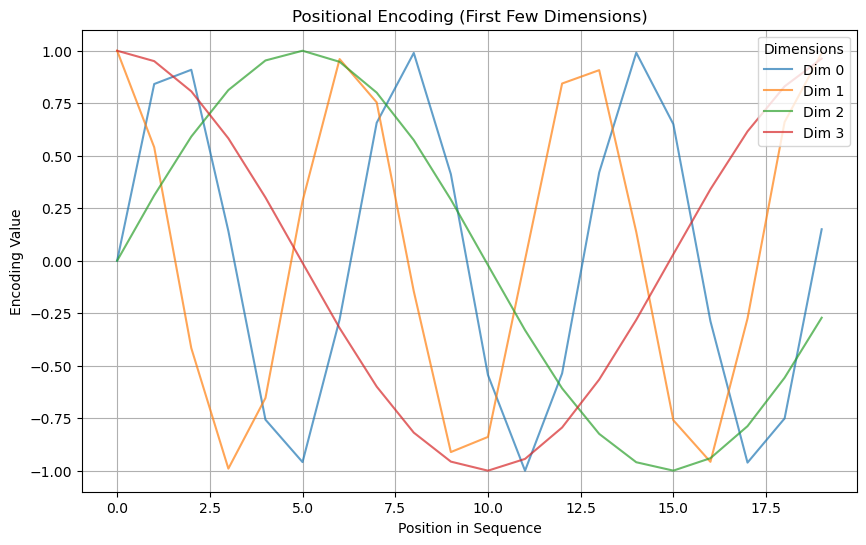

In [24]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Define parameters
d_model = 16  # Embedding size 
max_len = 20  # Maximum sequence length

# Compute positional encodings
pos = np.arange(max_len)[:, np.newaxis]
div_term = np.exp(np.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
pos_enc = np.zeros((max_len, d_model))
pos_enc[:, 0::2] = np.sin(pos * div_term)
pos_enc[:, 1::2] = np.cos(pos * div_term)

# Plot positional encoding
plt.figure(figsize=(10, 6))
for i in range(4):  # Show only first 4 dimensions for clarity
    plt.plot(pos, pos_enc[:, i], label=f"Dim {i}", alpha=0.7)

plt.title("Positional Encoding (First Few Dimensions)")
plt.xlabel("Position in Sequence")
plt.ylabel("Encoding Value")
plt.legend(loc="upper right", title="Dimensions")
plt.grid(True)
plt.show()

### 2.2 Multi-Head Self-Attention

This layer implements multi-head self-attention.

##### If we  have a semtemce
        The cat sat on the mat.
        when the model process  the word 'sat' it shoud focuse on 'CAT' (subject) rather than mat which is less relevent.

        Self-attention solves this by allowing each word to look at all other words in the sentence 
        and assign different importance (weights) to them.
        """

##### How to do it
    Step 1: compute Queries, keys and Values
        for each word we comput the below vectores
        -   Query (Q) What I am looking for? (in our example "sat")
        -   Key (K) How relevent is this word to the query
        -   Value (V) The actual meaning of the word.
        compute these vectore using linear algebra
        Q = XW_q, K= XW_k, V = XW_v

    Step2: 
    compute attention score
![title](Pics/attention%202.PNG)

    Step 3: 
        single attention mechanism, Multi-Head Attention uses multiple attention heads to capture different relationships in the text.
![title](Pics/Multi_head.PNG)

In [ ]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads


        self.wq = layers.Dense(d_model) # query (What am I looking for? ( in our example "sat" should look for "cat"))
        self.wk = layers.Dense(d_model) # key how relevent us  this word to query
        self.wv = layers.Dense(d_model) # the actual meaming
        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        # x shape: (batch_size, seq_len, d_model)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # Transpose to shape: (batch_size, num_heads, seq_len, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x):
        batch_size = tf.shape(x)[0]
        q = self.wq(x)  # (batch_size, seq_len, d_model)
        k = self.wk(x)
        v = self.wv(x)

        # Split heads
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (batch_size, num_heads, seq_len, seq_len)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        scaled_attention = tf.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, depth)

        # Concatenate heads
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output

# Test MultiHeadSelfAttention
sample_mha = MultiHeadSelfAttention(d_model=16, num_heads=4)
dummy_input = tf.random.uniform((1, 10, 16))
print('MultiHeadSelfAttention output shape:', sample_mha(dummy_input).shape)

MultiHeadSelfAttention output shape: (1, 10, 16)


### 2.3 Feed-Forward Network

A simple two-layer feed-forward network.

In [52]:
class FeedForward(layers.Layer):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.dense1 = layers.Dense(d_ff, activation='relu')
        self.dense2 = layers.Dense(d_model)

    def call(self, x):
        return self.dense2(self.dense1(x))

# Test FeedForward
sample_ff = FeedForward(d_model=16, d_ff=32)
print('FeedForward output shape:', sample_ff(dummy_input).shape)

FeedForward output shape: (1, 10, 16)


### 2.4 Transformer Block

This block combines the multi-head self-attention and feed-forward network with residual connections and layer normalization.

In [53]:
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x, training):
        attn_output = self.att(x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Test TransformerBlock
sample_tb = TransformerBlock(d_model=16, num_heads=4, d_ff=32)
print('TransformerBlock output shape:', sample_tb(dummy_input, training=False).shape)

TransformerBlock output shape: (1, 10, 16)


### 2.5 Tiny Transformer Language Model

This model stacks the embedding, positional encoding, and multiple Transformer blocks to predict the next token.

In [54]:
class TinyTransformerLM(keras.Model):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_len):
        super(TinyTransformerLM, self).__init__()
        self.token_embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.transformer_layers = [TransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)]
        self.dropout = layers.Dropout(0.1)
        self.final_layer = layers.Dense(vocab_size)

    def call(self, x, training=False):
        # x shape: (batch, seq_len)
        x = self.token_embedding(x)
        x = self.pos_encoding(x)
        for layer in self.transformer_layers:
            x = layer(x, training=training)
        x = self.dropout(x, training=training)
        logits = self.final_layer(x)
        return logits

# The model will be used later for training.

## 3. Preprocessing a Real-World Text

For this lab, you can extract text from a webpage. The examples below show how to do that.

### 3.1 Extracting Text from a Webpage

We'll use **Requests** and **BeautifulSoup** to extract text from a webpage.

In [63]:
import requests
from bs4 import BeautifulSoup

def extract_text_from_webpage(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Remove script and style elements
    for element in soup(['script', 'style', 'meta', 'link', 'noscript']):
        element.decompose()
     # Extract text and clean up whitespace
    text = soup.get_text(separator=' ')
    text = '/n'.join(line.strip() for line in text.splitlines() if line.strip())

    return text


#text_data = extract_text_from_webpage("https://gist.githubusercontent.com/sgsinclair/f895f2b37cdee761ac08e4ed8cc83d58/raw/b675c976913a939b325f7f2ee4ab4b3b396edd35/CharlesDickens-OliverTwist.txt")
new_text = extract_text_from_webpage("https://fa.wikipedia.org/wiki/%D8%A7%DB%8C%D8%B1%D8%A7%D9%86")

In [80]:
new_text

"ایران - ویکی\u200cپدیا، دانشنامهٔ آزاد/nپرش به محتوا/nمنوی اصلی/nمنوی اصلی/nانتقال به نوار کناری/nنهفتن/nبازدید محتوا/nصفحهٔ اصلی رویدادهای کنونی مقالهٔ تصادفی صفحه\u200cهای ویژه/nهمکاری/nتغییرات اخیر ویکی\u200cنویس شوید! راهنما تماس با ویکی\u200cپدیا/nجستجو/nجستجو/nظاهر/nکمک مالی/nساخت حساب/nورود/nابزارهای شخصی/nکمک مالی   ساخت حساب   ورود/nصفحه\u200cهایی برای ویرایشگرانی که از سامانه خارج شدند  بیشتر بدانید/nمشارکت\u200cها بحث/nفهرست/nانتقال به نوار کناری/nنهفتن/nبخش آغازین/n۱/nریشه\u200cشناسی نام/nتغییر وضعیت زیربخش\u200cهای ریشه\u200cشناسی نام/n۱.۱/nایران/n۱.۲/nواژه\u200cهای برگرفته از پارس/n۲/nتاریخ/nتغییر وضعیت زیربخش\u200cهای تاریخ/n۲.۱/nپیشاتاریخ/n۲.۲/nدوران باستان/n۲.۲.۱/nکوروش بزرگ و شاهنشاهی هخامنشی/n۲.۲.۲/nدوران هلنیستی و پایان هخامنشیان/n۲.۲.۳/nشاهنشاهی اشکانی/n۲.۲.۴/nشاهنشاهی ساسانی/n۲.۳/nورود اسلام، میان\u200cدورهٔ ایرانی و حملهٔ مغول/n۲.۴/nدوران مدرن نخستین و ایران مدرن/n۲.۴.۱/nصفویان/n۲.۴.۲/nافشاریان/n۲.۴.۳/nزندیان/n۲.۴.۴/nقاجاریان/n۲.۴.۵/nدودمان پهلوی/n۲.۴.۶/nجمهوری 

### 3.2 Preprocessing and Tokenization

For simplicity, we'll use word-level tokenization. In practice, you might use more advanced tokenizers.

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('perluniprops')
nltk.download('nonbreaking_prefixes')

In [ ]:


def preprocess_text(text):
    # Lowercase text
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation (keep words)
    text = re.sub(r'[^a-zA-Zآ-ی\s]', '', text)  # Keeps only Persian and English words
    # tokenise
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english')) 
    try:
        stop_words = set(stopwords.words('persian'))  
    except:
        pass
    tokens = [word for word in tokens if word is not stop_words]
    return tokens
    

In [82]:
tokens = preprocess_text(new_text)
vocab = sorted(set(tokens))

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\N1259534/nltk_data'
    - 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\nltk_data'
    - 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\share\\nltk_data'
    - 'c:\\Users\\N1259534\\AppData\\Local\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\N1259534\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [65]:
# Basic preprocessing: lowercasing and splitting into words
text_data = new_text.lower()
tokens = text_data.split()

# Build vocabulary (sorted set of words)
vocab = sorted(set(tokens))
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Encode the entire text into a list of integers
encoded_text = [word2idx[word] for word in tokens]

print('Vocabulary size:', len(vocab))
print('Sample encoded text:', encoded_text[:10])

Vocabulary size: 661
Sample encoded text: [343, 4, 542, 411, 309, 369, 481, 332, 331, 369]


In [67]:
vocab[1:120]

['(ابهام\u200cزدایی)',
 '(میلادی)',
 '(پیش',
 '-',
 './n۳',
 '.lojban.',
 '/',
 '32;',
 '54/nبررسی\u200cشده/nاز',
 ':',
 'acèh',
 'afrikaans',
 'alemannisch',
 'anarâškielâ',
 'aragonés',
 'area',
 'armãneashti',
 'arpetan',
 'asturianu',
 'attribution/share-alike',
 "avañe'ẽ",
 'ayisyen',
 'azərbaycanca',
 'bahasa',
 'bali',
 'banyumasan',
 'basa',
 'batak',
 'betawi',
 'bibsys',
 'bikol',
 'bislama',
 'bizaad',
 'bnc',
 'bne',
 'bnf',
 'boarisch',
 'bokmål',
 'bosanski',
 'brezhoneg',
 'bân-lâm-gú',
 'canticn',
 'català',
 'cebuano',
 'central',
 'chavacano',
 'chi-chewa',
 'chishona',
 'chitumbuka',
 'cinii',
 'commons',
 'corsu',
 'creative',
 'cymraeg',
 'dagbanli',
 'dansk',
 'davvisámegiella',
 'de',
 'deitsch',
 'deutsch',
 'diné',
 'dolnoserbski',
 'e',
 'eesti',
 'emiliàn',
 'emu',
 'english',
 'español',
 'esperanto',
 'estremeñu',
 'euskara',
 'faka-tonga',
 'fast',
 'fiji',
 'franca',
 'français',
 'frysk',
 'fulfulde',
 'føroyskt',
 'gaeilge',
 'gaelg',
 'gagana',
 'gagau

### 3.3 Creating Training Examples

We'll use a sliding window approach. For a given sequence length, the model will learn to predict the next token.

In [46]:
sequence_length = 10  # Adjust as needed
inputs = []
targets = []

for i in range(len(encoded_text) - sequence_length):
    inputs.append(encoded_text[i:i+sequence_length])
    targets.append(encoded_text[i+1:i+sequence_length+1])

inputs = np.array(inputs)
targets = np.array(targets)

print('Number of training samples:', inputs.shape[0])

Number of training samples: 32553


### 3.4 Creating a tf.data.Dataset

Now, we create a dataset for training.

In [57]:
batch_size = 64
buffer_size = 10000

dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

print('Dataset ready.')

Dataset ready.


## 4. Training the Model

Set hyperparameters, compile the model, and train it.

In [55]:
# Hyperparameters
vocab_size = len(vocab)
d_model = 128 # total embedding dimention size (usully 16, 64, 512)
num_heads = 4
d_ff = 256
num_layers = 2
max_len = sequence_length

# Instantiate the model
model = TinyTransformerLM(vocab_size, d_model, num_heads, d_ff, num_layers, max_len)

# Compile the model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_object)

# Train the model
epochs = 5  # Increase if needed
model.fit(dataset, epochs=epochs)

Epoch 1/5

508/508 [==============================] - 31s 55ms/step - loss: 6.7487
Epoch 2/5
508/508 [==============================] - 29s 57ms/step - loss: 3.6159
Epoch 3/5
508/508 [==============================] - 39s 76ms/step - loss: 1.1114
Epoch 4/5
508/508 [==============================] - 44s 87ms/step - loss: 0.5225
Epoch 5/5
508/508 [==============================] - 38s 74ms/step - loss: 0.4193


## 5. Generating Text

After training, use the model to generate text from a seed phrase.

In [58]:
def generate_text(model, start_text, gen_length=100):
    print (start_text, end=" ")
    # Tokenize the starting text
    tokens = start_text.lower().split()
    input_seq = [word2idx[word] for word in tokens if word in word2idx]
    input_seq = tf.expand_dims(input_seq, 0)  # shape: (1, current_seq_len)

    generated = tokens.copy()
    last_word=tokens[-1]
    for _ in range(gen_length):
        predictions = model(input_seq, training=False)  # (1, seq_len, vocab_size)
        last_logits = predictions[0, -1, :]
        predicted_id = tf.random.categorical(tf.expand_dims(last_logits, 0), num_samples=1)[0, 0].numpy()
        new_word=idx2word[predicted_id]
        print (new_word, end=" ") if (new_word!=last_word) else None
        last_word=new_word

        # Append the new token and trim the sequence if necessary
        input_seq = tf.concat([input_seq, tf.expand_dims([predicted_id], 0)], axis=1)
        if input_seq.shape[1] > sequence_length:
            input_seq = input_seq[:, -sequence_length:]

# Generate text using a seed phrase
generated_text = generate_text(model, start_text="Oliver leaned his head upon his hand and")

Oliver leaned his head upon his hand and sons. and sons. and sons. p. sons. isbn sons. p. 366. ↑ stephen kinzer (2011). all medieval and sons. p. sons. p. sons. p. first steps and sons. p. sons. p. sons. oswyn murray; lisa r. brody (2005). press. p. peters; served referred to the militarization in years and art. 18 of iran. cambridge islamic civilization: an human rights nelson cambridge university press. tauris. isbn 978-1-118-14440-4. ↑ 18 of iran. 4. cambridge university press. p. 46. isbn 978-1-118-14440-4. retrieved 21 june 2020. retrieved 2021-04-15. ↑ https://en.irna.ir/news/83161183/8-000-years-old-artifacts-unearthed-in-piranshahr 

## 6. Discussion & Experimentation

- Try changing hyperparameters (like `num_layers`, `d_model`, `sequence_length`, etc.)
- Experiment with different text data (e.g., a chapter from a public-domain book)
- Discuss how scaling the model and dataset affects performance

Happy coding and experimenting!